# Imports

In [1]:
import random
import sys

import importlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics

import data_visualisation as dv
import data_augmentation as da


2024-08-20 12:12:27.591402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 12:12:28.105623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-08-20 12:12:28.105683: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-08-20 12:12:28.105690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Load the Data

In [5]:
# load data
thismodule = sys.modules[__name__]

with np.load('data/PTB_XL_HB_1s_window.npz', allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

# Augments

In [9]:
def mask_ecg(ecg, mask_ratio=0.1):
    block_size = 20
    
    for lead in range(ecg.shape[1]):
        for i in range(0, ecg.shape[0], block_size):
            if random.random() < mask_ratio:
                ecg[i:i+block_size, lead] = 0
    return ecg

def mask_lead(ecg, mask_ratio=0.1):

    for lead in range(ecg.shape[1]):
        if random.random() < mask_ratio:
            ecg[:, lead] = 0
    return ecg

In [7]:
def mask_ecg(ecg, mask_ratio=0.1, block_size=20):
    ecg_shape = tf.shape(ecg)
    num_blocks = ecg_shape[0] // block_size
    
    mask = tf.random.uniform([num_blocks, ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    mask = tf.reshape(tf.tile(mask[:, None, :], [1, block_size, 1]), ecg_shape)
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

def mask_lead(ecg, mask_ratio=0.1):
    ecg_shape = tf.shape(ecg)
    print(ecg_shape[0], ecg_shape[1])
    mask = tf.random.uniform([ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    print(mask.shape)
    mask = tf.tile(mask[None, :], [ecg_shape[0], 1])
    print(mask.shape)
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

In [11]:
def mask_lead(ecg, mask_ratio=0.1):


    mask = tf.random.uniform([ecg.shape[1]], minval=0, maxval=1) > mask_ratio
    # mask is now a 1,12 matrix
    mask = mask[None, :]
    # mask is now a 100,12 matrix
    mask = tf.tile(mask, [ecg.shape[0], 1])
    # mask is now a 100,12 matrix with mask_ratio * 100 rows = true and the rest false
    mask = tf.cast(mask, tf.float32)
    return ecg * mask


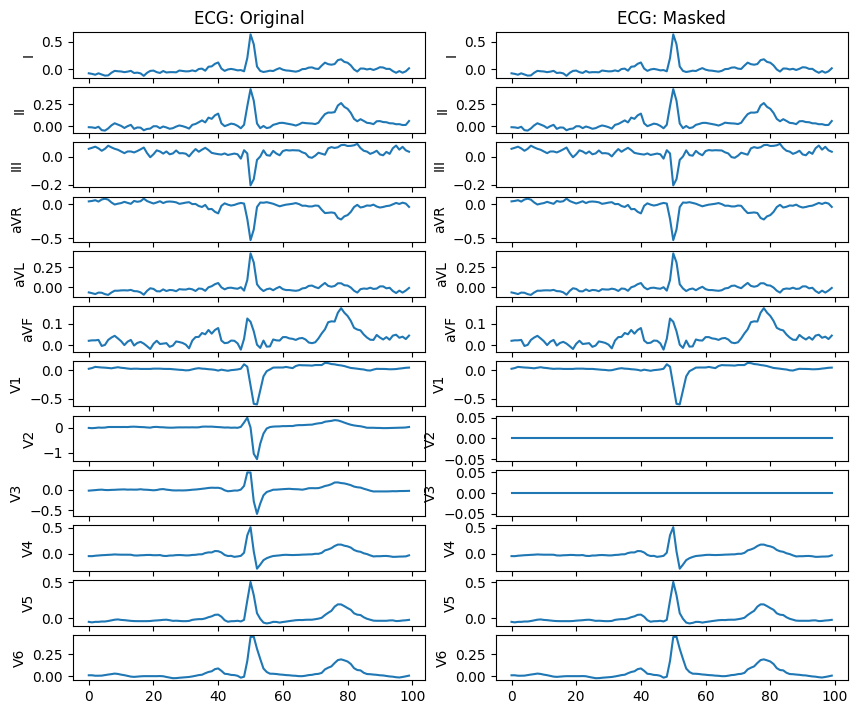

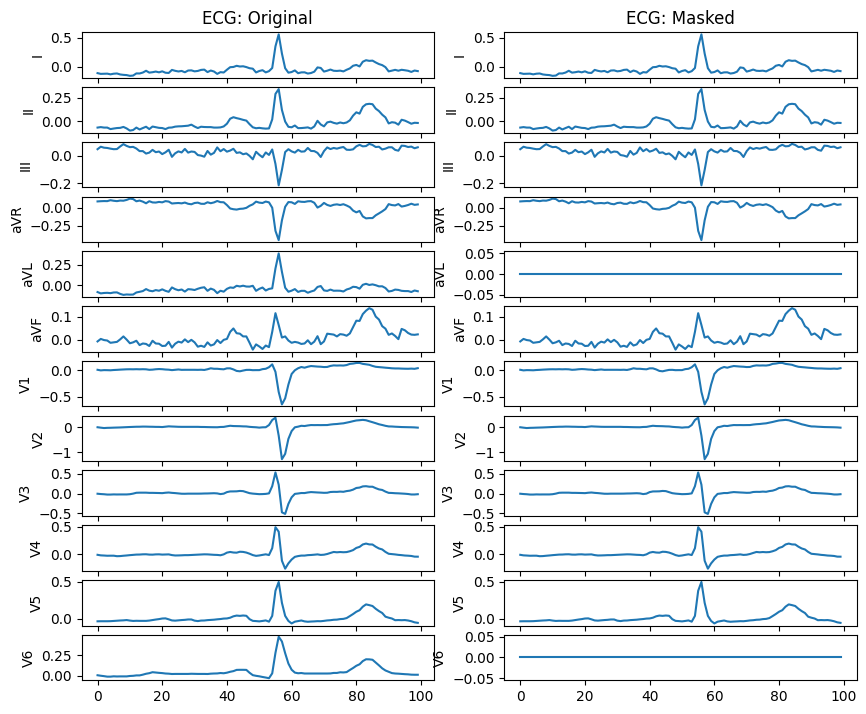

In [66]:
ecg2 = X_train[2]
ecg1 = X_train[1]

inp = np.array([ecg1,ecg2])

ecgs_a = mask_lead(inp, mask_ratio=0.2)

dv.plot_12_lead_ecgs([ecg2, ecgs_a[1]], ['Original', 'Masked'])
dv.plot_12_lead_ecgs([ecg1, ecgs_a[0]], ['Original', 'Masked'])

In [4]:
def augment_ecg_signal(signal):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(1.5,2.5), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0, 0.2))
    res = mask_lead(noised_drifted_signal, mask_ratio=0.2)
    return res

# Train Loop (Unused atm)

In [5]:
def train_autoencoder(model, data, epochs=50, batch_size=32):
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        steps = len(X_train) // batch_size
        for step, batch in enumerate(dataset):
            # augmented_batch = tf.map_fn(augment_ecg_signal, batch)

            with tf.GradientTape() as tape:
                reconstructed = model(batch, training=True)
                loss = loss_fn(batch, reconstructed)
            
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            print(f"\rEpoch {epoch+1}/{epochs}, Step {step}/{steps}, Loss: {loss.numpy():.4f}", end='')
        model.save(f'model-weights/autoencoder_{epoch+1}.h5')
        
        # print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}')

# Auto Encoder

In [3]:
# Allow memory growth for the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[]


2024-06-11 22:29:48.267388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2024-06-11 22:29:48.267421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: raaif-ubuntu
2024-06-11 22:29:48.267430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: raaif-ubuntu
2024-06-11 22:29:48.267525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 550.67.0
2024-06-11 22:29:48.267556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 550.54.15
2024-06-11 22:29:48.267565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 550.54.15 does not match DSO version 550.67.0 -- cannot find working devices in this configuration


In [6]:
# def encoder(inputs, latent_dim):
#     # 100 x 12
#     X = layers.Conv1D(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv1')(inputs)
#     # 96 x 24
#     X = layers.MaxPooling1D(2)(X)
#     X = layers.Dropout(0.2)(X)
#     # 48 x 32
#     X = layers.Conv1D(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv2')(X)
#     # 44 x 48
#     X = layers.MaxPooling1D(2)(X)
#     X = layers.Dropout(0.2)(X)
#     # 22 x 48
#     X = layers.Conv1D(64, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv3')(X)
#     # 18 x 64
#     X = layers.MaxPooling1D(2)(X)
#     X = layers.Dropout(0.2)(X)
#     # 9 x 64
#     X = layers.Flatten()(X)
#     # 1152
#     X = layers.Dense(latent_dim, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-encode')(X)
#     # latent_dim
#     return X

# def decoder(latent_rep, latent_dim):
#     X = layers.Dense(9*64, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-decode')(latent_rep)
#     # 1152
#     X = layers.Reshape((9, 64))(X)
#     # 9 x 64
#     X = layers.UpSampling1D(2)(X)
#     # 18 x 64
#     X = layers.Conv1DTranspose(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv1')(X)
#     # 22 x 48
#     X = layers.UpSampling1D(2)(X)
#     # 44 x 48
#     X = layers.Conv1DTranspose(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv2')(X)
#     # 48 x 24
#     X = layers.UpSampling1D(2)(X)
#     # 96 x 24
#     X = layers.Conv1DTranspose(12, 5, activation='linear', padding='valid', name='upconv3')(X)
#     # 100 x 12
#     return X

def encoder(inputs, latent_dim):
    # 100 x 12
    X = layers.Conv1D(24, 5, activation='linear', padding='same', name='conv1')(inputs)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 100 x 24
    X = layers.MaxPooling1D(2, padding='same')(X)
    X = layers.Dropout(0.3)(X)
    # 50 x 24
    X = layers.Conv1D(48, 5, activation='linear', padding='same', name='conv2')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 50 x 48
    X = layers.MaxPooling1D(2, padding='same')(X)
    X = layers.Dropout(0.3)(X)
    # 25 x 48
    X = layers.Conv1D(64, 5, activation='linear', padding='same', name='conv3')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 25 x 64
    X = layers.MaxPooling1D(2, padding='same')(X)
    X = layers.Dropout(0.3)(X)
    # 13 x 64
    X = layers.Flatten()(X)
    # 832
    X = layers.Dense(latent_dim, activation='linear', name='dense-encode')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    return X

def decoder(latent_rep, latent_dim):
    X = layers.Dense(13*64, activation='linear', name='dense-decode')(latent_rep)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.Reshape((13, 64))(X)
    # 13 x 64
    X = layers.UpSampling1D(2)(X)
    # 26 x 64
    X = layers.Conv1DTranspose(48, 5, activation='linear', padding='same', name='upconv1')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 26 x 48
    X = layers.UpSampling1D(2)(X)
    # 52 x 48
    X = layers.Conv1DTranspose(24, 5, activation='linear', padding='same', name='upconv2')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 52 x 24
    X = layers.UpSampling1D(2)(X)
    # 104 x 24
    X = layers.Conv1DTranspose(12, 5, activation='linear', padding='same', name='upconv3')(X)
    # 104 x 12
    X = layers.Cropping1D(cropping=(2, 2))(X)  # Cropping to get back to original input size
    # 100 x 12
    return X

def make_model(inputs, latent_dim):
    latent_rep = encoder(inputs, latent_dim)
    X = decoder(latent_rep, latent_dim)
    return keras.Model(inputs=inputs, outputs=X)
    
inputs = keras.Input(shape=X_train.shape[1:])
model = make_model(inputs, latent_dim=256)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1 (Conv1D)              (None, 100, 24)           1464      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 24)           0         
                                                                 
 batch_normalization (BatchN  (None, 100, 24)          96        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 24)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 24)            0     

2024-06-11 22:30:02.123972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Split the data into training and validation sets
validation_split = 0.2
num_val_samples = int(validation_split * len(X_train))
num_train_samples = len(X_train) - num_val_samples

X_train_data = X_train
X_val_data = X_test

# Create tf.data.Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_data, X_train_data))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_data, X_val_data))

2024-05-31 15:20:44.690295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 15:20:44.749844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 15:20:44.750070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 15:20:44.750816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [13]:
def mask_lead(ecg, mask_ratio=0.1):
    batch_size = tf.shape(ecg)[0]
    time_steps = ecg.shape[1]
    num_leads = ecg.shape[2]

    mask = tf.random.uniform([batch_size, num_leads], minval=0, maxval=1) > mask_ratio
    mask = tf.tile(mask[:, tf.newaxis, :], [1, time_steps, 1])
    mask = tf.cast(mask, tf.float32)
    ecg = tf.cast(ecg, tf.float32)
    return ecg * mask

In [62]:
train_dataset = train_dataset.map(lambda x, y: (mask_lead(x, mask_ratio=0.1), y))

In [7]:
# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [67]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
7180/7180 [==============================] - 59s 8ms/step - loss: 0.0091 - val_loss: 0.0057
Epoch 2/10
7180/7180 [==============================] - 56s 8ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 3/10
7180/7180 [==============================] - 55s 8ms/step - loss: 0.0084 - val_loss: 0.0053
Epoch 4/10
7180/7180 [==============================] - 56s 8ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 5/10
7180/7180 [==============================] - 57s 8ms/step - loss: 0.0082 - val_loss: 0.0054
Epoch 6/10
7180/7180 [==============================] - 58s 8ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 7/10
7180/7180 [==============================] - 58s 8ms/step - loss: 0.0080 - val_loss: 0.0054
Epoch 8/10
7180/7180 [==============================] - 57s 8ms/step - loss: 0.0082 - val_loss: 0.0052
Epoch 9/10
7180/7180 [==============================] - 56s 8ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 10/10
7180/7180 [==============================] - 57s 8ms/step - l

# Testing

In [3]:
model = keras.models.load_model('temp/ae_10_epochs_ft_with_augment.h5')

2024-08-20 12:13:13.866532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-20 12:13:14.034910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-20 12:13:14.035132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-20 12:13:14.035773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

1/1 [==============================] - 0s 14ms/step


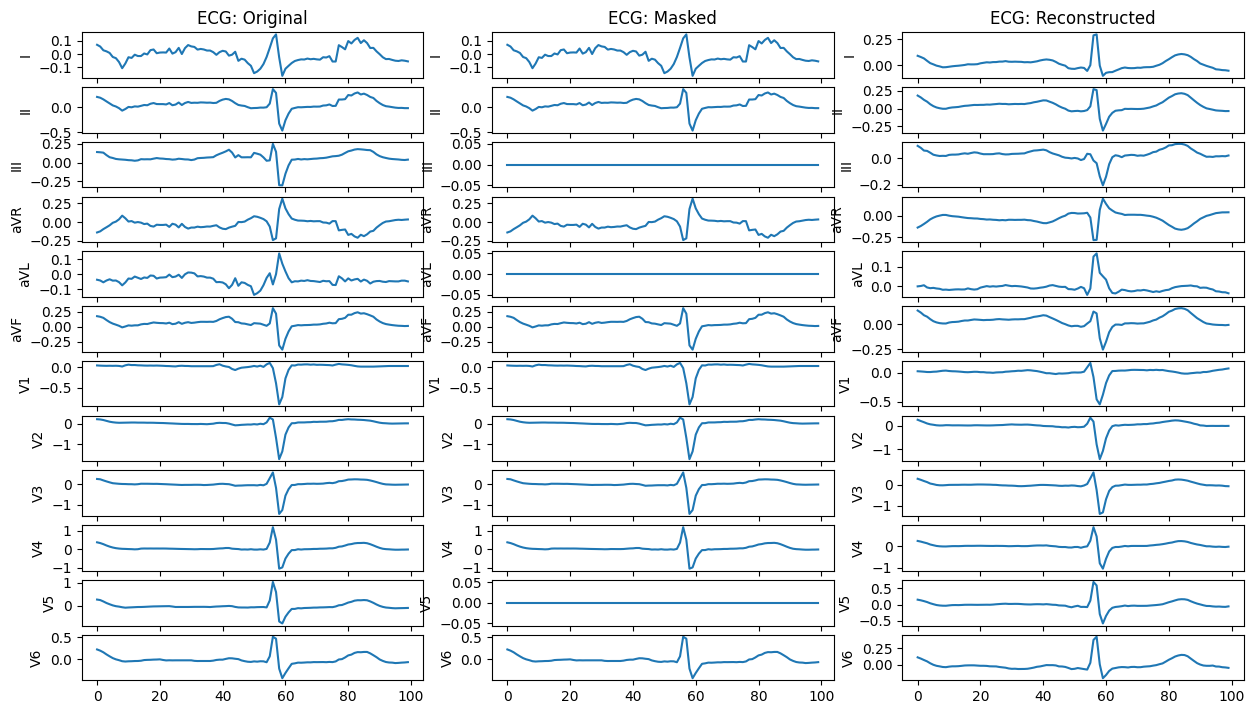

In [27]:
# get a random sample
idx = random.randint(0, X_train.shape[0])
sample = X_train[idx]


sample_arr = np.array([sample])

masked_sample = mask_lead(sample_arr, mask_ratio=0.2)[0]

# augmented_sample = augment_ecg_signal(sample)
# print(sample.shape, augmented_sample.shape)
# reconstructed_sample = model.predict(augmented_sample[None, ...])[0]
# print(reconstructed_sample.shape)
reconstructed_sample = model.predict(masked_sample[None, ...])[0]

# dv.plot_12_lead_ecgs([sample, augmented_sample, reconstructed_sample], ['Original', 'Augmented', 'Reconstructed'])
dv.plot_12_lead_ecgs([sample, masked_sample, reconstructed_sample], ['Original', 'Masked', 'Reconstructed'])

# Save the Model

In [68]:
model.save('temp/ae_10_epochs_ft_with_augment.h5')

# TSNE

In [25]:
inputs = keras.Input(shape=X_train.shape[1:])
enc = encoder(inputs, latent_dim=256)
encoder_model = keras.Model(inputs=inputs, outputs=enc)

encoder_model.load_weights('temp/ae2.h5', by_name=True)

(1000, 100, 12)
(1000, 256)


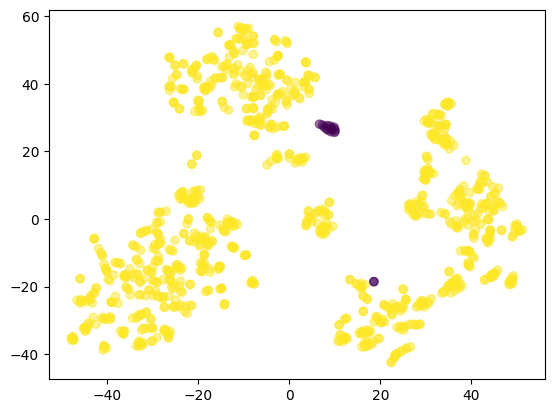

In [30]:
# tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model, signals, labels):
    representations = model(signals)
    print(representations.shape)
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000)
    tsne_transformed = tsne.fit_transform(representations)
    plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.show()


labels_Norm = [0 if "HYP" in x else 1 for x in Y_train_text[:1000]]
# labels_Norm = [1 if "NORM" in x else 0 for x in Y_train_text[:1000]]
# labels_Norm = [0 if len(x)==0 else 1 for x in Z_HB_text[:1000]]
print(X_train[:1000].shape)


plot_tsne(encoder_model, X_train[:1000], labels=labels_Norm)